In [1]:
import numpy as np
import matplotlib.pyplot as plt

IMPORT DATA

In [2]:
file_base =  "inertia"
# file_base = "penalty_implicit"
folder = "DATA"

# file_base2 = "lagr_mult"
# folder = "DATA"

In [3]:
# Carico parametri CSV
csv_file = f"{folder}/{file_base}.csv"
npz_file = f"{folder}/{file_base}.npz"

params_csv = np.genfromtxt(csv_file, delimiter=",", names=True)
resolution = float(params_csv["resolution"])
lx_f = float(params_csv["lx_f"])
ly_f = float(params_csv["ly_f"])
nu_f = float(params_csv["nu_f"])
lx_s = float(params_csv["lx_s"])
ly_s = float(params_csv["ly_s"])
E_s = float(params_csv["E_s"])
nu_s = float(params_csv["nu_s"])
rho_s = float(params_csv["rho_s"])
rho_f = float(params_csv["rho_f"])
dt = float(params_csv["dt"])
Nt  = int(params_csv["Nt"])


# Carico campi numerici NPZ
data = np.load(npz_file, allow_pickle=True)

u_f = data["u_f"]
v_f = data["v_f"]
p_f = data["p_f"]
u_s = data["u_s"]
v_s = data["v_s"]
a_s = data["a_s"]

P = data["P"]
T = data["T"]
d0_x_s = data["d0_x_s"]
d0_y_s = data["d0_y_s"]

print("✅ Data loaded successfully")


dx_f = resolution
dy_f = resolution

nx_f = np.floor(lx_f / dx_f).astype(int)
ny_f = np.floor(ly_f / dy_f).astype(int)

dx_s = resolution 
dy_s = resolution 

nx_s = np.floor(lx_s / dx_s).astype(int)
ny_s = np.floor(ly_s / dy_s).astype(int)
Nb = (nx_s + 1) * (ny_s + 1)

✅ Data loaded successfully


In [4]:
# Carico parametri CSV
# csv_file2 = f"{folder}/{file_base2}.csv"
# npz_file2 = f"{folder}/{file_base2}.npz"

# params_csv2 = np.genfromtxt(csv_file2, delimiter=",", names=True)
# resolution = float(params_csv2["resolution"])
# lx_f = float(params_csv2["lx_f"])
# ly_f = float(params_csv2["ly_f"])
# nu_f = float(params_csv2["nu_f"])
# lx_s = float(params_csv2["lx_s"])
# ly_s = float(params_csv2["ly_s"])
# E_s = float(params_csv2["E_s"])
# nu_s = float(params_csv2["nu_s"])
# dt = float(params_csv2["dt"])
# Nt  = int(params_csv2["Nt"])


# # Carico campi numerici NPZ
# data = np.load(npz_file2, allow_pickle=True)
# u_f = data["u_f"]
# v_f = data["v_f"]
# p_f = data["p_f"]
# u_s2 = data["u_s"]
# v_s2 = data["v_s"]
# P2 = data["P"]
# T2 = data["T"]
# d0_x_s = data["d0_x_s"]
# d0_y_s = data["d0_y_s"]

# print("✅ Data loaded successfully")


# dx_f = resolution
# dy_f = resolution

# nx_f = np.floor(lx_f / dx_f).astype(int)
# ny_f = np.floor(ly_f / dy_f).astype(int)

# dx_s = resolution 
# dy_s = resolution 

# nx_s = np.floor(lx_s / dx_s).astype(int)
# ny_s = np.floor(ly_s / dy_s).astype(int)
# Nb = (nx_s + 1) * (ny_s + 1)

FLUID interpolation

In [5]:
def interpolation(usol, vsol, psol,nx, ny, fine = False):
    """
    Fine interpolation: at each pressure volume, we have 4 velocity subdomains, 
    so we can divide each control volume in 4 equal subvolumes, each ones 
    with a values of u and v depending on the corresponding u and v volume
    """
    u_int = []
    v_int = []
    p_int = []
    if fine:
        u_fine = np.zeros((2*nx, 2*ny))
        v_fine = np.zeros((2*nx, 2*ny))
        for t in range(len(usol)):
            u = usol[t]
            v = vsol[t]
            p = psol[t]
            for i in range(nx):
                for j in range(ny):
                    u_left = u[i,j]       
                    u_right = u[i,j+1]    
                    u_fine[2*i:2*i+2, 2*j]   = u_left
                    u_fine[2*i:2*i+2, 2*j+1] = u_right
                    v_bottom = v[i,j]     
                    v_top = v[i+1,j]   
                    v_fine[2*i, 2*j:2*j+2]   = v_bottom
                    v_fine[2*i+1, 2*j:2*j+2] = v_top

            p_int.append(p[1:-1, 1:-1]) 
            u_int.append(u_fine)
            v_int.append(v_fine)

    else:
        for t in range(len(usol)):
            u = usol[t]
            v = vsol[t]
            p = psol[t]
            
            p_int.append(p[1:-1, 1:-1]) 
            u_int.append((u[1:-1, 2:] + u[1:-1, 1:-1]) * 0.5)
            v_int.append((v[2: , 1:-1] + v[1:-1 , 1:-1]) * 0.5)
    return u_int, v_int, p_int

u_f, v_f, p_f = interpolation(u_f, v_f, p_f, nx_f, ny_f, False)

PLOTS - VISUALIZATION

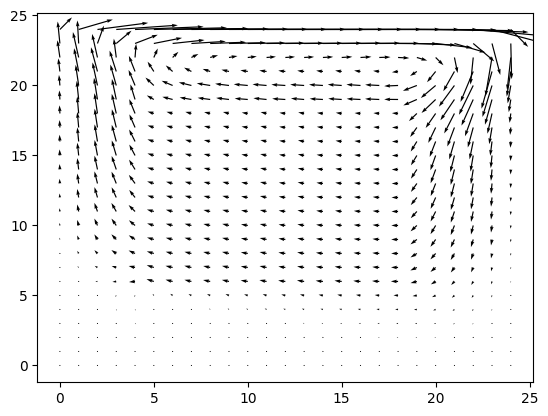

In [6]:
# plt.quiver(u_f[0], v_f[0])
# plt.quiver(u_f[100], v_f[100])
plt.quiver(u_f[-1], v_f[-1])


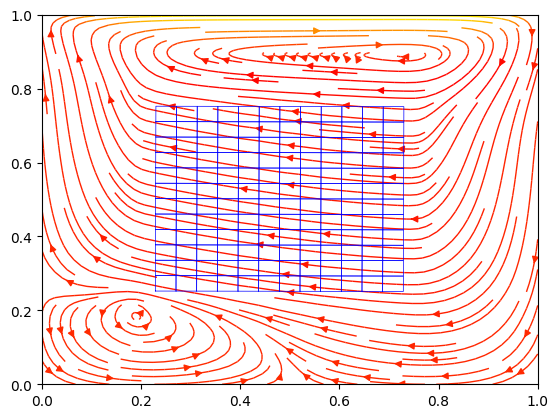

In [7]:
x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)


x_def = P[0, :] + u_s[-1][:Nb] + d0_x_s
y_def = P[1, :] + u_s[-1][Nb:] + d0_y_s
plt.streamplot(xx, yy, u_f[-1], v_f[-1], color=u_f[-1], density=1.5, cmap=plt.cm.autumn, linewidth=1.0)
for e in range(T.shape[1]):
    node_ids = T[:, e]
  
    x_coords = [x_def[i] for i in node_ids] + [x_def[node_ids[0]]] 
    y_coords = [y_def[i] for i in node_ids] + [y_def[node_ids[0]]]
    plt.plot(x_coords, y_coords, color='blue', linewidth=0.5)

plt.xlim(0, lx_f)
plt.ylim(0, ly_f)
plt.show()

Video

In [8]:
from pathlib import Path
output_dir = Path("frames_1")
output_dir.mkdir(parents=True, exist_ok=True) 

x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)

j = 0
for i in range(Nt):
    if i % 5 == 0:
        fig, ax = plt.subplots(figsize=[7, 4], dpi=200)

        uf = u_f[i]
        vf = v_f[i]
        us = u_s[i]
        x_def = P[0, :] + us[:Nb] + d0_x_s
        y_def = P[1, :] + us[Nb:] + d0_y_s

        speed = np.sqrt(uf**2 + vf**2)

        plt.contourf(xx, yy, speed)
        plt.streamplot(xx, yy, uf, vf, color=speed, density=1.0, cmap=plt.cm.autumn, linewidth=1.0)

        for e in range(T.shape[1]):
            node_ids = T[:, e]

            x_coords = [x_def[i] for i in node_ids] + [x_def[node_ids[0]]] 
            y_coords = [y_def[i] for i in node_ids] + [y_def[node_ids[0]]]
            plt.plot(x_coords, y_coords, color='white', linewidth=1.0)

        plt.xlim(0, lx_f)
        plt.ylim(0, ly_f)

        plt.savefig(output_dir / f"frame_{j:04d}.png")
        j += 1
        plt.close()

In [9]:
print(u_s[-1])

[-0.02094845 -0.02086657 -0.02077111 -0.02067976 -0.02058674 -0.02049304
 -0.02039868 -0.02030552 -0.02020891 -0.02011415 -0.0200171  -0.01991313
 -0.01978748 -0.02095858 -0.02086441 -0.02077067 -0.02067659 -0.02058309
 -0.02048876 -0.02039498 -0.02030067 -0.02020676 -0.02010992 -0.02001413
 -0.01991313 -0.01980625 -0.02095961 -0.02086745 -0.02077476 -0.02068051
 -0.02058633 -0.02049279 -0.02039875 -0.02030434 -0.02020896 -0.02011466
 -0.02001403 -0.01991673 -0.01981234 -0.02096718 -0.02086685 -0.02077458
 -0.02067918 -0.02058499 -0.02049075 -0.02039692 -0.02030242 -0.02020839
 -0.02010896 -0.02001643 -0.01991628 -0.01981941 -0.02096742 -0.0208739
 -0.0207785  -0.02068468 -0.02059023 -0.02049632 -0.02040207 -0.02030772
 -0.02021276 -0.02011629 -0.02001926 -0.01992239 -0.01982215 -0.02097082
 -0.02087602 -0.02078054 -0.02068597 -0.02059182 -0.02049774 -0.02040363
 -0.02030942 -0.02021492 -0.02011975 -0.02002286 -0.01992622 -0.01982636
 -0.02097419 -0.02087711 -0.02078166 -0.02068642 -0.

NameError: name 'u_s2' is not defined

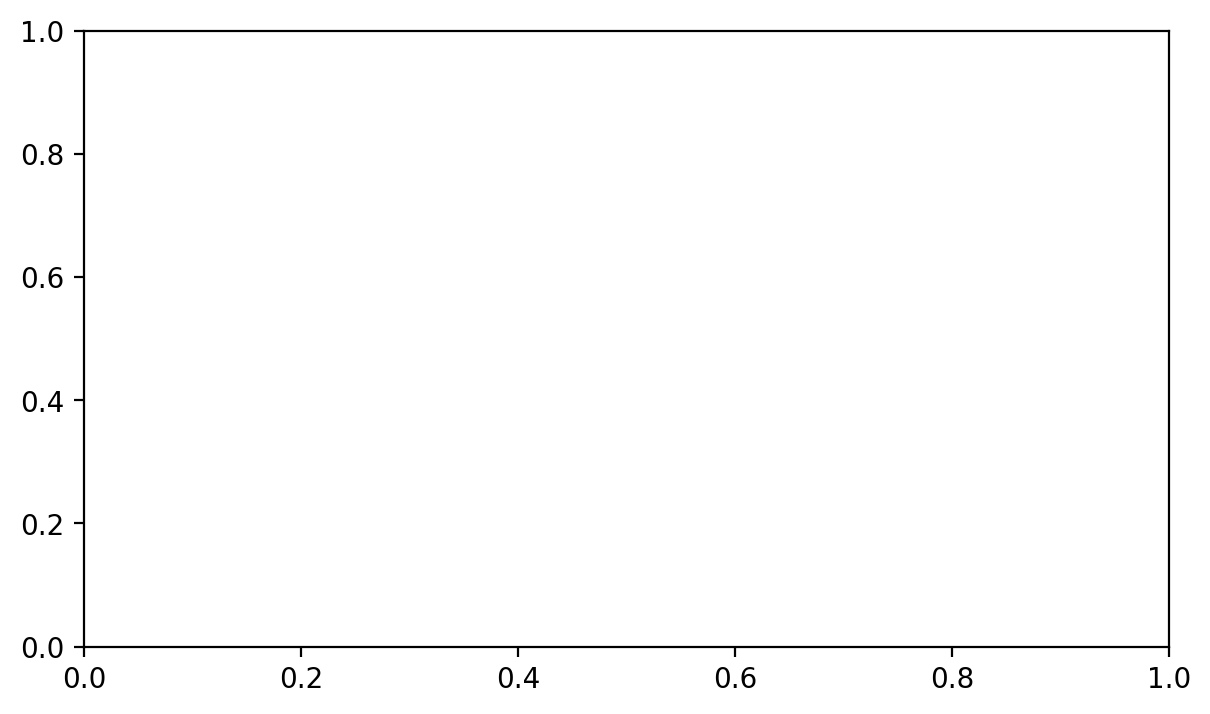

In [10]:
from pathlib import Path
output_dir = Path("frames_comparison")
output_dir.mkdir(parents=True, exist_ok=True) 

x = np.linspace(0, lx_f, nx_f)
y = np.linspace(0, ly_f, ny_f)
xx, yy = np.meshgrid(x,y)

j = 0
for i in range(Nt):
    if i % 5 == 0:
        fig, ax = plt.subplots(figsize=[7, 4], dpi=200)

        us1 = u_s[i]
        us2 = u_s2[i]
        x_def1 = P[0, :] + us1[:Nb] + d0_x_s
        y_def1 = P[1, :] + us1[Nb:] + d0_y_s

        x_def2 = P[0, :] + us2[:Nb] + d0_x_s
        y_def2 = P[1, :] + us2[Nb:] + d0_y_s

    

        for e in range(T.shape[1]):
            node_ids = T[:, e]

            x_coords = [x_def1[i] for i in node_ids] + [x_def1[node_ids[0]]] 
            y_coords = [y_def1[i] for i in node_ids] + [y_def1[node_ids[0]]]
            plt.plot(x_coords, y_coords, color='blue', linewidth=1.0)

            x_coords2 = [x_def2[i] for i in node_ids] + [x_def2[node_ids[0]]] 
            y_coords2 = [y_def2[i] for i in node_ids] + [y_def2[node_ids[0]]]
            plt.plot(x_coords2, y_coords2, color='red', linewidth=1.0)



        plt.xlim(0, lx_f)
        plt.ylim(0, ly_f)

        plt.savefig(output_dir / f"frame_{j:04d}.png")
        j += 1
        plt.close()